In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy, pickle
import matplotlib

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc
from neurolib.optimal_control import cost_functions as cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_singlenode
import scipy

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

18.895652173913046
minima =  [ 110  299  488  677  866 1055 1244 1433 1622 1811 2000 2189 2378 2567
 2756 2944 3133 3322 3511 3700 3889 4078 4267 4456 4645 4834]


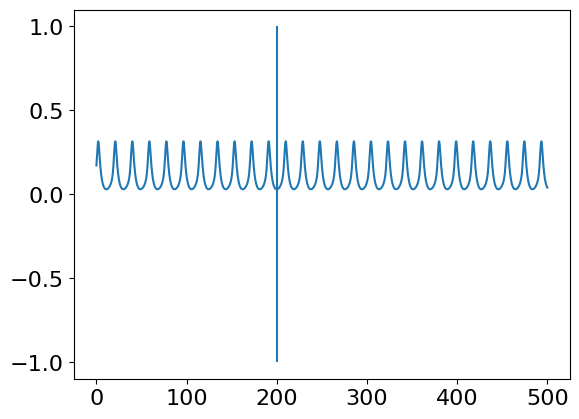

In [2]:
wc = WCModel()
wc.params.sigma_ou = 0.

dt = 0.1
wc.params.dt = dt

duration = 500.
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]
input = zero_control.copy()

wc.params["duration"] = duration
x_init = 0.045135938287846025
y_init = 0.08586538415443892
wc.params["exc_init"] = np.array([[x_init]])
wc.params["inh_init"] = np.array([[y_init]])

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

wc.run()
peaks = scipy.signal.find_peaks(wc.exc[0,:])[0]
p_list = []
for i in range(3,len(peaks)):
    p_list.append(peaks[i]- peaks[i-1])
period = np.mean(p_list)*dt

print(period)

init_min = [wc.exc[0,188+87], wc.inh[0,188+87]]
wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])
wc.run()
target_min = np.concatenate((np.concatenate( (wc.params["exc_init"], wc.params["inh_init"]), axis=1)[:,:, np.newaxis], np.stack( (wc.exc, wc.inh), axis=1)), axis=2)

mins = scipy.signal.find_peaks(-wc.exc[0,:])[0]
print("minima = ", mins)

plt.plot(wc.t, wc.exc[0,:])
plt.vlines(200,-1,1)
plt.show()

In [3]:
control_mat = np.zeros( (wc.params.N, len(wc.state_vars)) )
control_mat[0,0] = 1.
control_mat[0,1] = 1.

prec_mat = np.zeros( (wc.params.N, len(wc.output_vars)) )
prec_mat[0,0] = 1.
prec_mat[0,1] = 1.

int0, int1 = 2000, None

duration = 300.
wc.params["duration"] = duration
zero_input = ZeroInput().generate_input(duration=duration+dt, dt=dt)
zero_control =np.vstack( [zero_input, zero_input] )[np.newaxis,:,:]

wc.params["exc_ext"] = zero_input + 1.
wc.params["inh_ext"] = zero_input

In [26]:
def increase_step_compute():
    wc_controlled.step = 1e-2
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(200)

    wc_controlled.step = 1e-1
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(200)

    wc_controlled.step = 1e0
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(400)
    
    wc_controlled.step = 1e1
    wc_controlled.zero_step_encountered = False
    wc_controlled.optimize(1000)

    return

def get_values(results_dict, ish, w1):
    results_dict["control"][ish] = wc_controlled.control.copy()
    results_dict["state"][ish] = wc_controlled.get_xs().copy()
    results_dict["total_cost"][ish] = wc_controlled.cost_history[-1]

    wc_controlled.w_1T = 0.
    wc_controlled.simulate_forward()
    results_dict["precision_cost"][ish] = wc_controlled.compute_total_cost()
    results_dict["L1_cost_weighted"][ish] = ( results_dict["total_cost"][ish] - results_dict["precision_cost"][ish]) 
    results_dict["L1_cost_unweighted"][ish] = results_dict["L1_cost_weighted"][ish] / w1
    wc_controlled.w_1T = w1

    return

def get_period_index_target(period, i_sh, n_points, target_in):
    p = i_sh* 2.* np.pi / (n_points-1)
    index = np.round(p * period/ ( 2. * np.pi)/ dt).astype(int)
    target = target_in[:,:,index:index+np.round(1+duration/dt,1).astype(int)]

    return p, index, target

def getmodel(target_shift, w1, results_dict, ish):
    wc_controlled = oc_wc.OcWc(wc, target=target_shift, w_p=1, w_2=0., w_1T=w1, print_array=np.arange(0,2001,200), precision_cost_interval=(int0,int1), control_matrix=control_mat, precision_matrix=prec_mat)

    if type(results_dict["control"][ish]) != type(None):
        wc_controlled.control = results_dict["control"][ish].copy()
        wc_controlled.update_input()
    wc_controlled.model.run()    

    return wc_controlled

In [27]:
n_points = 41
w_array = [1.]

results_min = dict([
    ('w1', w_array),
    ("total_cost", [None] * n_points),
    ("initial_cost", [None] * n_points),
    ("precision_cost", [None] * n_points),
    ("L1_cost_unweighted", [None] * n_points),
    ("L1_cost_weighted", [None] * n_points),
    ("control", [None] * n_points),
    ("state", [None] * n_points),
    ])

In [28]:
import IPython
filename = IPython.extract_module_locals()[1]['__vsc_ipynb_file__'].split("/")[-1][:-6]
print(filename)

def save(results_dict):
    filehandler = open((filename + ".pickle"),"wb")
    pickle.dump(results_dict,filehandler)
    filehandler.close()

def read():
    filehandler = open((filename + ".pickle"),"rb")
    results_dict = pickle.load(filehandler)
    filehandler.close()

    return results_dict

def readfile(file):
    filehandler = open(file,"rb")
    results_dict = pickle.load(filehandler)
    filehandler.close()

    return results_dict

a_s2_l1t


In [24]:
results_min = read()


FileNotFoundError: [Errno 2] No such file or directory: 'a_s2_l1t.pickle'

In [53]:
wc.params["exc_init"] = np.array([[init_min[0]]])
wc.params["inh_init"] = np.array([[init_min[1]]])

ind_list = range(41)
options = [True, True, True]

for k in range(10):

    w1 = results_min['w1'][0]

    for i_shift in range(n_points):
        
        if type(results_min["control"][i_shift]) != type(None):
            continue

        period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)

        wc_controlled = getmodel(target_shift, w1, results_min, i_shift)

        wc_controlled.step = 1e-3
        wc_controlled.optimize(100)

        if i_shift in [0, n_points-1]:
            get_values(results_min, i_shift, w1)
            continue

        increase_step_compute()
        get_values(results_min, i_shift, w1)

    save(results_min)

    if options[0]:
        print("----------------------------------------------- 0")
        for i_shift in range(2, n_points-1):

            period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
            wc_controlled = getmodel(target_shift, w1, results_min, i_shift)
            
            factor = (0.95+np.random.random()*0.1)
            
            wc_controlled.control = results_min["control"][i_shift-1].copy() * factor
            wc_controlled.update_input()

            wc_controlled.step = 1e-3
            wc_controlled.zero_step_encountered = False
            wc_controlled.optimize(200)

            increase_step_compute()

            if wc_controlled.cost_history[-1] < results_min["total_cost"][i_shift]:
                print("-----------------------------------------------")
                print("0 found better solution, ", i_shift)

                get_values(results_min, i_shift, w1)

        save(results_min)

    if options[1]:
        print("----------------------------------------------- 1")
        for i_shift in range(n_points-3, 0, -1):

            period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
            wc_controlled = getmodel(target_shift, w1, results_min, i_shift)

            factor = (0.95+np.random.random()*0.1)
            
            wc_controlled.control = results_min["control"][i_shift+1].copy() * factor
            wc_controlled.update_input()
            wc_controlled.simulate_forward()

            increase_step_compute()

            if wc_controlled.cost_history[-1] < results_min["total_cost"][i_shift]:
                print("-----------------------------------------------")
                print("1 found better solution, ", i_shift)

                get_values(results_min, i_shift, w1)

        save(results_min)

    if options[2]:
        print("----------------------------------------------- 4")
        for i_shift in range(1, n_points-1):

            period_shift, index_shift, target_shift = get_period_index_target(period, i_shift, n_points, target_min)
            wc_controlled = getmodel(target_shift, w1, results_min, i_shift)
            
            wc_controlled.control = results_min["control"][i_shift].copy() * (0.95+np.random.random()*0.1)
            wc_controlled.control[0,0,int0+np.around(period/dt).astype(int):] = 0.
            wc_controlled.control[0,1,int0+np.around(period/dt).astype(int):] = 0.
            wc_controlled.update_input()

            wc_controlled.step = 1e-3
            wc_controlled.zero_step_encountered = False
            wc_controlled.optimize(200)

            increase_step_compute()

            if wc_controlled.cost_history[-1] < results_min["total_cost"][i_shift]:
                print("-----------------------------------------------")
                print("4 found better solution, ", i_shift)

                get_values(results_min, i_shift, w1)

        save(results_min)

    save(results_min)

----------------------------------------------- 0
Compute control for a deterministic system
Cost in iteration 0: 0.05471635276765263
Converged in iteration 124 with cost 0.02597550767152698 because of vanishing difference
Final cost : 0.02597550767152698
Compute control for a deterministic system
Cost in iteration 0: 0.02597550767152698
Converged in iteration 1 with cost 0.02597550767152698 because of step counter
Final cost : 0.02597550767152698
Compute control for a deterministic system
Cost in iteration 0: 0.02597550767152698
Converged in iteration 1 with cost 0.02597550767152698 because of step counter
Final cost : 0.02597550767152698
Compute control for a deterministic system
Cost in iteration 0: 0.02597550767152698
Converged in iteration 1 with cost 0.02597550767152698 because of step counter
Final cost : 0.02597550767152698
Compute control for a deterministic system
Cost in iteration 0: 0.02597550767152698
Converged in iteration 1 with cost 0.02597550767152698 because of step c

In [45]:
save(results_min)

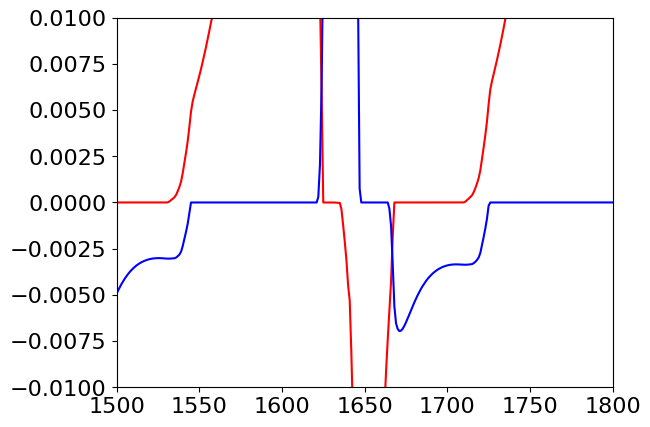

In [54]:
plt.plot(results_min["control"][20][0,0,:], color="red")
plt.plot(results_min["control"][20][0,1,:], color="blue")

plt.ylim(-0.01, 0.01)
plt.xlim(1500,1800)
plt.show()

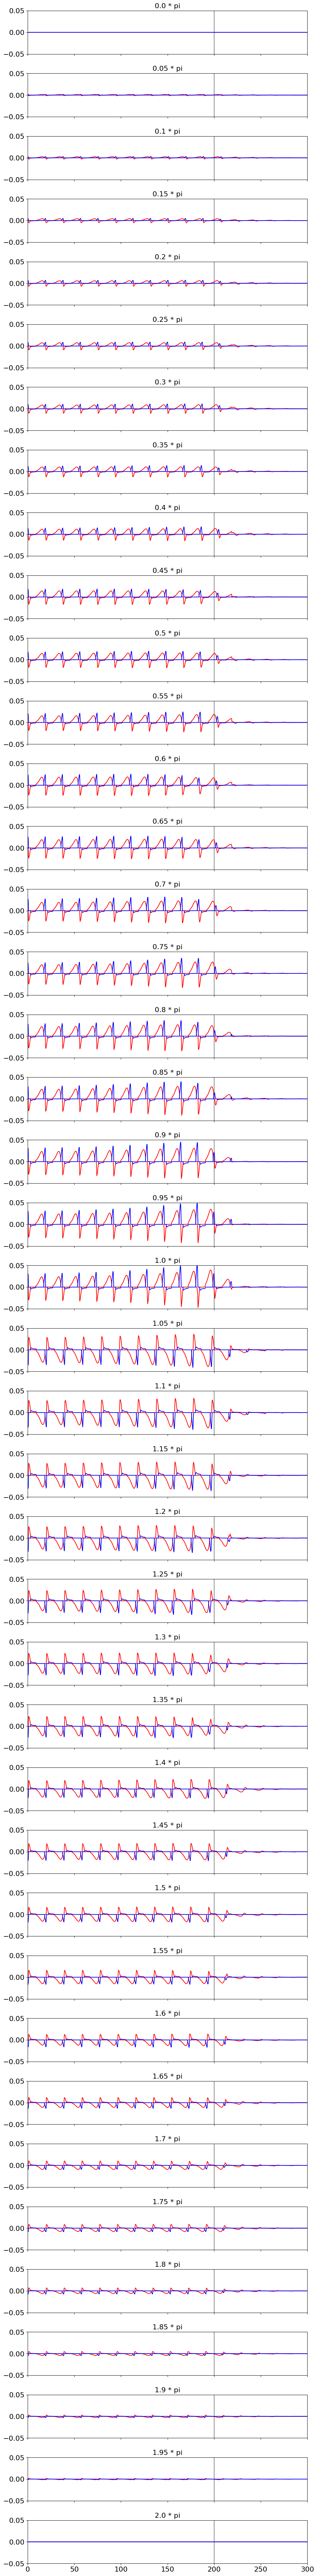

In [55]:
from neurolib.optimal_control.oc_utils.plot_oc import ops_plotall

ops_plotall(results_min["control"], 0.05, 300, dt, 200, "")